In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats

In [2]:
location = '../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation'
promoter_pref='promoters_5UTR'
file_names='non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../../data/output/{file_names}/genes/{promoter_pref}_czechowski_constitutive_variable_random.txt'
GC_content_tsv = f'../../../data/output/{file_names}/rolling_window/GC_content_rw/{promoter_pref}_GCcontent_rw.tsv'
EPD_TSS_bed = f'../../../data/EPD_promoter_analysis/EPDnew_promoters/At_EPDnew.bed'
promoter_bed = f'{location}/FIMO/{promoter_pref}.bed'
promoter_no_5UTR = f'{location}/promoters.gff3'

In [3]:
#bp covered chromatin files
root_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw/{promoter_pref}_root_bpcovered_rw.bed'
shoot_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw/{promoter_pref}_shoot_bpcovered_rw.bed'
rootshootintersect_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw/{promoter_pref}_rootshootintersect_bpcovered_rw.bed'

In [4]:
#make directory for the plots to be exported to
dirName = f'{location}/rolling_window/GC_content_rw/plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/rolling_window/GC_content_rw/plots  already exists


In [5]:
promoters = pd.read_csv(Czechowski_gene_categories, sep='\t', header=None)
cols = ['AGI','gene_type']
promoters.columns = cols
GC_content = pd.read_table(GC_content_tsv, sep='\t', header=None)
GC_content
cols2 = ['name', 'percentage_GC_content']
GC_content.columns = cols2
#Make AGI column
GC_content['AGI'] = GC_content.name.str.split('_',expand=True)[0]
#make window number column
GC_content = GC_content.assign(window_number=GC_content.name.str.extract(r'_(.*?)\:'))
#make chr column
GC_content = GC_content.assign(chr=GC_content.name.str.split(':',n=3,expand=True)[2])
#make start column
GC_content = GC_content.assign(start=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[0])
#make stop column
GC_content = GC_content.assign(stop=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[1])
#make df columns integars
GC_content = GC_content.astype({'stop':'int','start':'int','chr':'int'})
#add window length column
GC_content = GC_content.assign(window_length=GC_content.stop - GC_content.start)

# #merge to limit to genes of interest
# GC_content = pd.merge(promoters, GC_content, how ='left', on='AGI')
# GC_content

In [6]:
GC_content

,name,percentage_GC_content,AGI,window_number,chr,start,stop,window_length
0,AT1G01010_21::1:2659-2759,39.0,AT1G01010,21,1,2659,2759,100
1,AT1G01010_20::1:2709-2809,36.0,AT1G01010,20,1,2709,2809,100
2,AT1G01010_19::1:2759-2859,36.0,AT1G01010,19,1,2759,2859,100
3,AT1G01010_18::1:2809-2909,34.0,AT1G01010,18,1,2809,2909,100
4,AT1G01010_17::1:2859-2959,37.0,AT1G01010,17,1,2859,2959,100
...,...,...,...,...,...,...,...,...
363248,AT5G67640_17::5:26971348-26971448,37.0,AT5G67640,17,5,26971348,26971448,100
363249,AT5G67640_18::5:26971398-26971498,38.0,AT5G67640,18,5,26971398,26971498,100
363250,AT5G67640_19::5:26971448-26971548,38.0,AT5G67640,19,5,26971448,26971548,100
363251,AT5G67640_20::5:26971498-26971598,40.0,AT5G67640,20,5,26971498,26971598,100


In [7]:
#allow colour codes in seaborn
sns.set(color_codes=True)
sns.set_style("white")

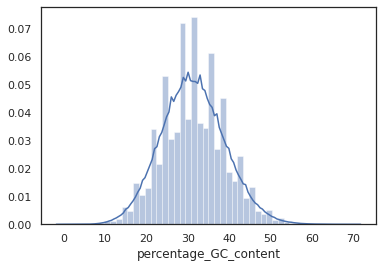

In [8]:
dist_plot = GC_content['percentage_GC_content']
#create figure with no transparency
dist_plot_fig = sns.distplot(dist_plot).get_figure()

In [9]:
#remove windows with fewer than 100 promoters extending to that location
GC_content = GC_content[GC_content['window_number'].map(GC_content['window_number'].value_counts()) > 99]

In [10]:
def add_coverage(df,coverage_bed,suffix):
    """add % bp covered data from a bed file to the df. Prefix is a name added to any new columns"""
    #read in bed file
    coverage_df = pd.read_table(coverage_bed, sep='\t', header=None)
    cols = ['chr','start','stop','name','no._of_overlaps', 'no._of_bases_covered','window_length','fraction_bases_covered']
    coverage_df.columns = cols
    #add % bases covered column
    coverage_df['percentage_bases_covered'] = coverage_df['fraction_bases_covered'] * 100
    #filter columns
    coverage_df = coverage_df[['chr','start','stop','name','percentage_bases_covered']]
    #make df columns integars
    df = df.astype({'stop':'int','start':'int','chr':'int'})
    coverage_df = coverage_df.astype({'stop':'int','start':'int','chr':'int'})
    #merge the dfs
    merged = pd.merge(df,coverage_df, how='left',on=['chr','start','stop'],suffixes=('', f'_{suffix}'))
    #remove NaN
    #merged = merged[merged['name'].notnull()] 
    return merged

In [53]:
def windows_coords(output_prefix,variable_of_interest,variable_of_interest_name,variable_of_interest_df,promoter_bed,promoter_no_5UTR,
                   window_offset,EPD_TSS_bed,includeEPDTSS=False,chromatin_tissue_variable='percentage_bases_covered_rootshootintersect_chrom',
                   chromatin_tissue_variable_name='% open chromatin root and shoot intersect',x_range=False,estimator='mean',ci=95, n_boot=1000, 
                   genetype=False, genetype2=False, genetype3=False):
    """function to add the centre of each window corresponding to each window no. and return a lineplot. Also add promoter length distribution, Araport TSS distribution,
    EPD TSS distribution (add the most common TSS as documented on eukaryotic promoter database Arabidopsis last modified on EPD 06/06/2018)"""
    #read in bed file
    promoter_df = pd.read_table(promoter_bed, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot1', 'strand','source','type','dot2','attributes']
    promoter_df.columns = col
    #add promoter length column
    promoter_df['length'] = promoter_df.stop-promoter_df.start  
    #merge promoter_bed with variable_of_interest_df on AGI
    merged = pd.merge(variable_of_interest_df, promoter_df, on='AGI',  how='left',suffixes=('','_wholeprom'))
    #remove NaN
    merged = merged[merged[variable_of_interest].notnull()]
    #make columns integars
    merged = merged.astype({'stop_wholeprom':'int','start_wholeprom':'int','start':'int','stop':'int'})
    #split merged into 2 dfs by strand
    pos = merged[merged.strand == '+'].copy()
    neg = merged[merged.strand == '-'].copy()
    
    #add variable of interest position column where position is the middle of the window, with whole length of the longest promoter
    pos['position'] = (pos.stop_wholeprom) - (pos.start+0.5*(pos.stop-pos.start))
    neg['position'] = (neg.start+0.5*(neg.stop-neg.start)) - neg.start_wholeprom
    merged2 = pd.merge(pos,neg,how='outer')

    merged2 = merged2.astype({'position': 'int64'})
    #get longest transcript TSS distribution (if Araport 11 definition used)
    promoter_no_5UTR_df = pd.read_table(promoter_no_5UTR, sep='\t', header=None)
    col = ['chr', 'source', 'type', 'start','stop', 'dot1','strand','dot2','attributes']
    promoter_no_5UTR_df.columns = col
    #add AGI column
    promoter_no_5UTR_df_agi = promoter_no_5UTR_df.assign(AGI=promoter_no_5UTR_df.attributes.str.extract(r'ID=gene:(.*?)\;'))
    #merged with windows    
    merged2 = pd.merge(merged2,promoter_no_5UTR_df_agi, on='AGI', how='left', suffixes=('','_no_UTR'))
    #remove NaN (promoters in promoters.gff but not in promoters_5UTR)
    merged2 = merged2[merged2.length.notnull()]
    #remove NaN (promoters in promoters_5UTR but not in promoters.gff - ie. only 5'UTRs)
    merged2 = merged2[merged2.chr_no_UTR.notnull()]
    #Get most common transcript TSS location from eukaryotic promoter database (last modified on EPD 06/06/2018)
    #Note - not all promoters have a TSS on EPD
    EPD_TSS_df = pd.read_table(EPD_TSS_bed, delim_whitespace=True, header=None, skiprows=4)
    cols = ['chr','start','stop','transcript_EPD','score_EPD','strand_EPD','thickstart_EPD','thickend_EPD']
    EPD_TSS_df.columns = cols
    #add AGI column
    EPD_TSS_df['AGI'] = EPD_TSS_df.transcript_EPD.str.split('_',expand=True)[0]
    #add TSS location column
    EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '+', 'TSS_EPD'] = EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '+', 'thickstart_EPD']
    EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '-', 'TSS_EPD'] = EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '-', 'thickend_EPD'] -1
    #merged with windows
    merged2 = pd.merge(merged2,EPD_TSS_df, on='AGI', how='left', suffixes=('','_EPD'))

    #remove NaN (promoters in EPD but not in promoters_5UTR)
    merged2 = merged2[merged2.length.notnull()]   
    
    #calculate longest promoter length based on window cutoff
    number_of_windows = len(variable_of_interest_df.window_number.unique())
    window_length = variable_of_interest_df.window_length.max()    
    length_of_longest_promoter = number_of_windows*(window_length-window_offset)

    #make 0 start like in bed files
    merged2.start_no_UTR = merged2.start_no_UTR -1
    #add Araport TSS location column
    #merged2['TSS'] = int()
    merged2.loc[merged2.strand == '+', 'TSS'] = merged2.loc[merged2.strand == '+', 'stop_no_UTR']
    merged2.loc[merged2.strand == '-', 'TSS'] = merged2.loc[merged2.strand == '-', 'start_no_UTR'] -1
    #transform TSS location in the same way as the position column
    merged2.loc[merged2.strand == '-', 'TSS_transformed_Araport11'] = merged2.loc[merged2.strand == '-', 'TSS'] - merged2.loc[merged2.strand == '-','start_wholeprom']
    merged2.loc[merged2.strand == '+', 'TSS_transformed_Araport11'] = merged2.loc[merged2.strand == '+', 'stop_wholeprom'] - merged2.loc[merged2.strand == '+', 'TSS']
    #transfrom PED TSS column in the same way as the position column
    merged2.loc[merged2.strand == '-', 'TSS_transformed_EPD'] = merged2.loc[merged2.strand == '-', 'TSS_EPD'] - merged2.loc[merged2.strand == '-','start_wholeprom']
    merged2.loc[merged2.strand == '+', 'TSS_transformed_EPD'] = merged2.loc[merged2.strand == '+', 'stop_wholeprom'] - merged2.loc[merged2.strand == '+', 'TSS_EPD']
    
    #make integars
    merged2 = merged2.astype({'TSS_transformed_EPD':'float64','start_no_UTR':'float64','stop_no_UTR':'float64','TSS':'float64','TSS_transformed_Araport11':'float64',f'{variable_of_interest}':'float64',f'{chromatin_tissue_variable}':'float64'})
    #return merged2[['AGI','strand','start','stop','start_wholeprom','stop_wholeprom','start_no_UTR','stop_no_UTR','TSS','TSS_transformed','position','chr_no_UTR','window_number']]

    #make all values of interest negative as upstream from ATG
    merged_positive = merged2.copy()
    merged2[['length','TSS_transformed_Araport11','position','TSS_transformed_EPD']] = -merged2[['length','TSS_transformed_Araport11','position','TSS_transformed_EPD']]
    #change estimator
    if estimator == 'mean':
        new_estimator=estimator
        
    if estimator == 'median':
        new_estimator = np.median
    #set number of subplots so can easily change all output possibilities, where subplotA is the top
    subplots = 3
    
    #make subplots
    if includeEPDTSS == True:
        subplots = subplots + 1
        f, axes = plt.subplots(subplots, figsize=(10,10))
        OpenChromplot = axes[subplots-subplots]
        Araport11TSSplot = axes[subplots-(subplots-1)]
        EPDTSSplot = axes[subplots-(subplots-2)]   
        #promlengthsplot = axes[subplots-(subplots-3)]
        variableofinterestplot = axes[subplots-(subplots-3)]
    else:
        f, axes = plt.subplots(subplots, figsize=(10,8))
        OpenChromplot = axes[subplots-subplots]
        Araport11TSSplot = axes[subplots-(subplots-1)]
        #promlengthsplot = axes[subplots-(subplots-2)]
        variableofinterestplot = axes[subplots-(subplots-2)]

   
    
    #check the plot axes variables are there. If they are not, assign None to them
    try:
        OpenChromplot
    except NameError:
        OpenChromplot = None
    try:
        Araport11TSSplot
    except NameError:
        Araport11TSSplot = None
    try:
        EPDTSSplot
    except NameError:
        EPDTSSplot = None
#     try:
#         promlengthsplot
#     except NameError:
#         promlengthsplot = None
    try:
        variableofinterestplot
    except NameError:
        variableofinterestplot = None
    
    #If EPD TSS plot is present, filter promoters which aren't in EPD to remove NaNs
    if EPDTSSplot != None:
        #remove NaN (promoters in promoters_5UTR but not in promoters.gff - ie. only 5'UTRs)
        merged2 = merged2[merged2.TSS_transformed_EPD.notnull()]
    
    
    

    if genetype==False:
        
        #length_of_longest_promoter = merged_positive.length.max()
        #if openchromplot variable present, add that plot
        #next plot letter name
        nextletter = 'A'

        if OpenChromplot !=None:
            #Open chromatin lineplot
            sns.lineplot(y=merged2[chromatin_tissue_variable],x=merged2.position,ax=OpenChromplot,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles and axes labels
            OpenChromplot.set_title(f'{nextletter}: All promoters {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')
            OpenChromplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        
        #if Araport11TSSplot variable present, add that plot
        if Araport11TSSplot !=None:
            #AraportTSS distribution
            sns.distplot(merged2.TSS_transformed_Araport11, ax=Araport11TSSplot)
            #set titles and axes labels
            Araport11TSSplot.set_title(f'{nextletter}: All promoters Araport11 TSS position', weight='bold')
            #density is kernal density estimation
            Araport11TSSplot.set_ylabel('Density')
            Araport11TSSplot.set_xlabel('')
            Araport11TSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
            
        
        #if includeEPDTSS variable present, add that plot
        if includeEPDTSS ==True:
            #EPDTSS distribution
            sns.distplot(merged2.TSS_transformed_EPD, ax=EPDTSSplot)
            #set titles and axes labels
            EPDTSSplot.set_title(f'{nextletter}: All promoters EPD TSS position', weight='bold')
            EPDTSSplot.set_ylabel('Density')
            EPDTSSplot.set_xlabel('')
            EPDTSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        
    
        

        
        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[variable_of_interest], x=merged2.position, ax=variableofinterestplot,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterestplot.set_title(f'{nextletter}: All promoters sliding windows {variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position upstream of ATG')

               
    elif genetype2==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #next plot letter name
        nextletter = 'A'
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:        
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,
                         ax=OpenChromplot,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles and axes labels
            OpenChromplot.set_title(f'{nextletter}: {genetype} {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')
            OpenChromplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
            
        #if Araport11TSSplot variable present, add that plot
        if Araport11TSSplot !=None:
            #Araport11 TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_Araport11, ax=Araport11TSSplot)
            #set titles and axes labels
            Araport11TSSplot.set_title(f'{nextletter}: {genetype} Araport11 TSS position', weight='bold')
            #density is kernal density estimation
            Araport11TSSplot.set_ylabel('Density')
            Araport11TSSplot.set_xlabel('')
            Araport11TSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        #if includeEPDTSS variable present, add that plot
        if includeEPDTSS ==True:
            #EPD TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_EPD, ax=EPDTSSplot)
            #set titles and axes labels
            EPDTSSplot.set_title(f'{nextletter}: EPD TSS position', weight='bold')
            EPDTSSplot.set_ylabel('Density')
            EPDTSSplot.set_xlabel('')
            EPDTSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        
     
        

        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest], 
                         x=merged2[merged2.gene_type == genetype].position, ax=variableofinterestplot, estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles and axes labels
            variableofinterestplot.set_title(f'{nextletter}: {genetype} {variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position upstream of ATG')
            
        
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #variableofinterestplot.set_ylim([0,merged2.groupby('window_number')[variable_of_interest].median().max()+20])
        #set x axis range if specified 
#         if x_range==False:
#             pass
#         else:
#             length_of_longest_promoter = x_range
        
#         #for all subplots:
#         for n in axes:
#             #remove grids
#             n.grid(False)
#             n.set_xlim([-length_of_longest_promoter,0])        
#         f.tight_layout()
        
    elif genetype3==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #if openchromplot variable present, add that plot
        #add plot letter name
        nextletter = 'A'
        if OpenChromplot !=None:                      
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,ax=OpenChromplot,
                         estimator=new_estimator,label=genetype,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,ax=OpenChromplot,
                         estimator=new_estimator,label=genetype2,ci=ci, n_boot=n_boot)
            #set titles & axes names
            OpenChromplot.set_title(f'{nextletter}: {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')           
            OpenChromplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        #if Araport11TSSplot variable present, add that plot
        if Araport11TSSplot !=None:
            #Araport TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype2)
            #set titles & axes names
            Araport11TSSplot.set_title(f'{nextletter}: Araport11 TSS position', weight='bold')
            #density is kernal density estimation
            Araport11TSSplot.set_ylabel('Density')
            Araport11TSSplot.set_xlabel('')
            Araport11TSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        #if includeEPDTSS variable present, add that plot
        if includeEPDTSS ==True:
            #EPD TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype2)
            #set titles & axes names
            EPDTSSplot.set_title(f'{nextletter}: EPD TSS position', weight='bold')
            EPDTSSplot.set_ylabel('Density')
            EPDTSSplot.set_xlabel('')
            EPDTSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        #if promlengthsplot variable present, add that plot
        

        
        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #lineplot variable of interest
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest], x=merged2[merged2.gene_type == genetype].position,
                            ax=variableofinterestplot,label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest], x=merged2[merged2.gene_type == genetype2].position,
                            ax=variableofinterestplot,label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot) 
            #set titles & axes names
            variableofinterestplot.set_title(f'{nextletter}: {variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position upstream of ATG')
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #axes[2].set_ylim([0,merged2.groupby('window_number').percentage_bases_covered.median().max()+20])
        #gene_type labels
        gene_type_labels = [genetype, genetype2]
        # Create the legend
        axes[0].legend()

#         if x_range==False:
#             pass
#         else:
#             length_of_longest_promoter = x_range

#         #for all subplots:
#         for n in axes:
#             #remove grids
#             n.grid(False)
#             n.set_xlim([-length_of_longest_promoter,0])
#         f.tight_layout()
    else:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #add plot letter name
        nextletter = 'A'
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:                      
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,ax=OpenChromplot,
                         estimator=new_estimator,label=genetype,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,ax=OpenChromplot,
                         estimator=new_estimator,label=genetype2,ci=ci, n_boot=n_boot)
            sns.lineplot(y=merged2[merged2.gene_type == genetype3][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype3].position,ax=OpenChromplot,
                         estimator=new_estimator,label=genetype3,ci=ci, n_boot=n_boot)
            #set titles & axes names 
            OpenChromplot.set_title(f'{chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')           
            OpenChromplot.set_xticklabels([])   
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        #if Araport11TSSplot variable present, add that plot
        if Araport11TSSplot !=None:
            #Araport11 TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype2)
            sns.distplot(merged2[merged2.gene_type == genetype3].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype3)
            #set titles & axes names
            Araport11TSSplot.set_title(f'Araport11 TSS position', weight='bold')
            #density is kernal density estimation
            Araport11TSSplot.set_ylabel('Density')
            Araport11TSSplot.set_xlabel('')
            Araport11TSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        #if includeEPDTSS variable present, add that plot
        if includeEPDTSS ==True:
            #EPD TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype2)
            sns.distplot(merged2[merged2.gene_type == genetype3].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype3)
            #set titles & axes names
            EPDTSSplot.set_title(f'EPD TSS position', weight='bold')
            EPDTSSplot.set_ylabel('Density')
            EPDTSSplot.set_xlabel('')
            EPDTSSplot.set_xticklabels([])
            #change to next letter
            nextletter = chr(ord(nextletter) + 1) 
        


        
        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #lineplot
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest], x=merged2[merged2.gene_type == genetype].position, ax=variableofinterestplot,
                            label=genetype,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest], x=merged2[merged2.gene_type == genetype2].position, ax=variableofinterestplot,
                            label=genetype2,estimator=new_estimator,ci=ci, n_boot=n_boot)
            l3=sns.lineplot(y=merged2[merged2.gene_type == genetype3][variable_of_interest], x=merged2[merged2.gene_type == genetype3].position, ax=variableofinterestplot,
                            label=genetype3,estimator=new_estimator,ci=ci, n_boot=n_boot)
            #set titles & axes names      
            variableofinterestplot.set_title(f'{variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position upstream of ATG')
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #axes[2].set_ylim([0,merged2.groupby('window_number').percentage_bases_covered.median().max()+20])
        #gene_type labels
        gene_type_labels = [genetype, genetype2, genetype3]
        # Create the legend
        axes[0].legend()
        #set x axis length
#         if x_range==False:
#             pass
#         else:
#             length_of_longest_promoter = x_range

        
#         #for all subplots:
#         for n in axes:
#             #remove grids
#             n.grid(False)
#             n.set_xlim([-length_of_longest_promoter,0])
#             leg = n.legend()
#         f.tight_layout()
    #set x axis range if specified    
    if x_range==False:
        pass
    else:
        length_of_longest_promoter = x_range
        
    #for all subplots:
    
    for n in axes:
        #remove grids
        n.grid(False)
        n.set_xlim([-length_of_longest_promoter,0])
    #set a tight layout
    f.tight_layout()
    #save figure
    plt.savefig(f'../../../data/output/{file_names}/rolling_window/GC_content_rw/plots/{output_prefix}_{variable_of_interest}_sliding_window.pdf', format='pdf')    
    return merged2

In [59]:
def plot_length(df,output_prefix, genetype=False, genetype2=False, genetype3=False):
    """function to plot length distribution of promoter"""
    #make lengths posititive
    df.length = -df.length
    
    if genetype==False:
        dist_plot = df['length']
        #create figure with no transparency
        dist_plot_fig = sns.distplot(dist_plot,axlabel='length (bp)').get_figure()

    elif genetype2==False:
        sns.distplot(df[df.gene_type == genetype].length, label=genetype,axlabel='length (bp)')
        
    elif genetype3==False:
        plot = sns.distplot(df[df.gene_type == genetype].length,hist=None,label=genetype)
        sns.distplot(df[df.gene_type == genetype2].length,hist=None,label=genetype2,axlabel='length (bp)').get_figure()
        plt.legend()
    else:
        plot = sns.distplot(df[df.gene_type == genetype].length,hist=None,label=genetype)
        sns.distplot(df[df.gene_type == genetype2].length,hist=None,label=genetype2)
        sns.distplot(df[df.gene_type == genetype3].length,hist=None,label=genetype3,axlabel='length (bp)')
       # plt.axlabel='length (bp)'
        plt.legend()
    #tight layout
    plt.tight_layout()
    #save figure
    plt.savefig(f'../../../data/output/{file_names}/rolling_window/GC_content_rw/plots/{output_prefix}_promoter_lengths.pdf', format='pdf')
        

In [17]:
def add_genetype(df,gene_categories):
    """function to add gene type to the df, and remove random genes"""

    select_genes = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['AGI', 'gene_type']
    select_genes.columns = cols

    merged = pd.merge(select_genes, df, on='AGI', how='left')   
   # no_random = merged_renamed[merged_renamed.gene_type != 'random']
  #  no_random.reset_index(drop=True, inplace=True)
    
    return merged

In [18]:
GC_content.columns

Index(['name', 'percentage_GC_content', 'AGI', 'window_number', 'chr', 'start',
       'stop', 'window_length'],
      dtype='object')

In [19]:
#add root chromatin coverage data
GC_content = add_coverage(GC_content, root_chrom_bp_covered,'root_chrom')
#add shoot chromatin coverage data
GC_content = add_coverage(GC_content, shoot_chrom_bp_covered,'shoot_chrom')
#add rootshootintersect chromatin coverage data
GC_content = add_coverage(GC_content, rootshootintersect_chrom_bp_covered,'rootshootintersect_chrom')

In [20]:
GC_content

,name,percentage_GC_content,AGI,window_number,chr,start,stop,window_length,name_root_chrom,percentage_bases_covered,name_shoot_chrom,percentage_bases_covered_shoot_chrom,name_rootshootintersect_chrom,percentage_bases_covered_rootshootintersect_chrom
0,AT1G01010_21::1:2659-2759,39.0,AT1G01010,21,1,2659,2759,100,AT1G01010_21,100.0,AT1G01010_21,100.0,AT1G01010_21,100.0
1,AT1G01010_20::1:2709-2809,36.0,AT1G01010,20,1,2709,2809,100,AT1G01010_20,100.0,AT1G01010_20,100.0,AT1G01010_20,100.0
2,AT1G01010_19::1:2759-2859,36.0,AT1G01010,19,1,2759,2859,100,AT1G01010_19,100.0,AT1G01010_19,100.0,AT1G01010_19,100.0
3,AT1G01010_18::1:2809-2909,34.0,AT1G01010,18,1,2809,2909,100,AT1G01010_18,100.0,AT1G01010_18,100.0,AT1G01010_18,100.0
4,AT1G01010_17::1:2859-2959,37.0,AT1G01010,17,1,2859,2959,100,AT1G01010_17,100.0,AT1G01010_17,97.0,AT1G01010_17,97.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365641,AT5G67640_17::5:26971348-26971448,37.0,AT5G67640,17,5,26971348,26971448,100,AT5G67640_17,44.0,AT5G67640_17,5.0,AT5G67640_17,5.0
365642,AT5G67640_18::5:26971398-26971498,38.0,AT5G67640,18,5,26971398,26971498,100,AT5G67640_18,0.0,AT5G67640_18,0.0,AT5G67640_18,0.0
365643,AT5G67640_19::5:26971448-26971548,38.0,AT5G67640,19,5,26971448,26971548,100,AT5G67640_19,0.0,AT5G67640_19,0.0,AT5G67640_19,0.0
365644,AT5G67640_20::5:26971498-26971598,40.0,AT5G67640,20,5,26971498,26971598,100,AT5G67640_20,0.0,AT5G67640_20,0.0,AT5G67640_20,0.0


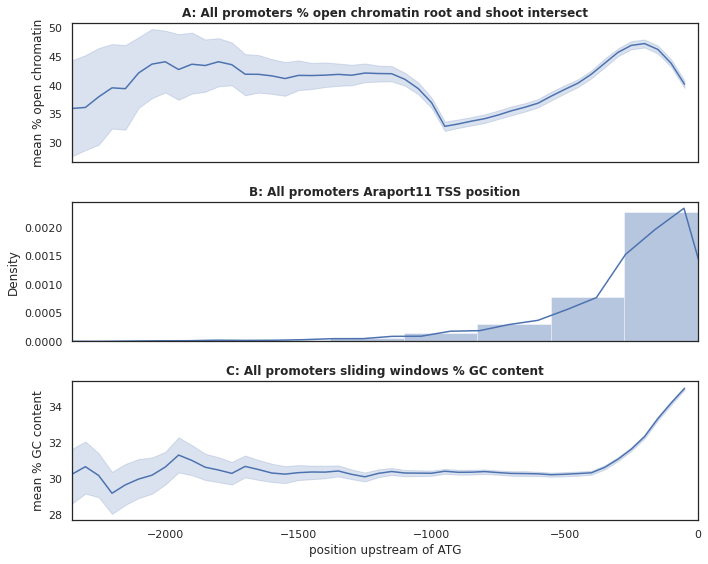

In [48]:
#all promoters in genome
all_proms = windows_coords('all_proms','percentage_GC_content','% GC content',GC_content,promoter_bed,promoter_no_5UTR,50,EPD_TSS_bed)

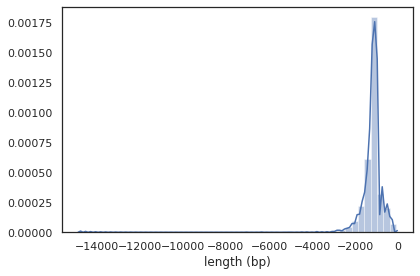

In [60]:
plot_length(all_proms,'allproms', genetype=False)

In [149]:
all_proms[all_proms.AGI=='AT4G24020'].TSS_EPD

126098    12479805.0
126099    12479805.0
126100    12479805.0
126101    12479805.0
126102    12479805.0
126103    12479805.0
126104    12479805.0
126105    12479805.0
126106    12479805.0
126107    12479805.0
126108    12479805.0
126109    12479805.0
126110    12479805.0
126111    12479805.0
126112    12479805.0
126113    12479805.0
126114    12479805.0
126115    12479805.0
126116    12479805.0
126117    12479805.0
126118    12479805.0
126119    12479805.0
126120    12479805.0
126121    12479805.0
126122    12479805.0
126123    12479805.0
Name: TSS_EPD, dtype: float64

## Now do constitutive and variable promoter from Czechowski et al 2005

In [33]:
GC_prom_types = add_genetype(GC_content, Czechowski_gene_categories)

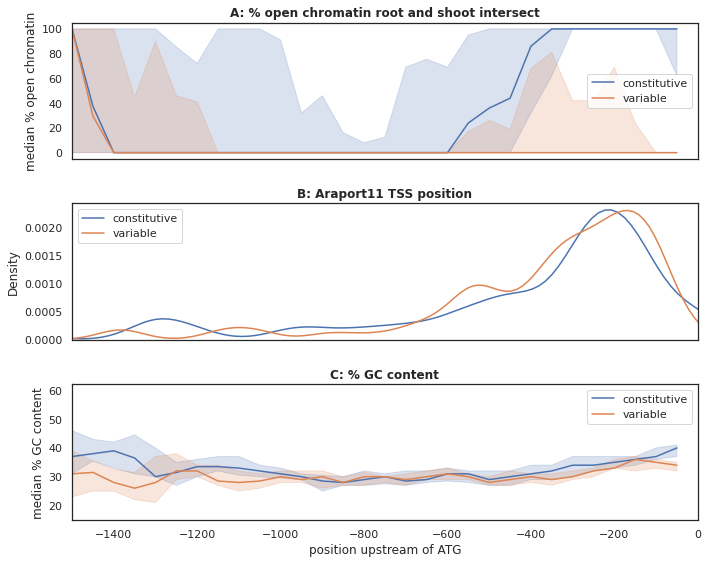

In [55]:
rolling_rootshootintersect = windows_coords('Czechowski_genetypenocontrol','percentage_GC_content','% GC content',GC_prom_types,promoter_bed,promoter_no_5UTR,
                         50,EPD_TSS_bed,includeEPDTSS=False,x_range=1500,estimator='median',  genetype='constitutive', genetype2='variable',ci=95, n_boot=10000)

In [35]:
GC_prom_types

,AGI,gene_type,name,percentage_GC_content,window_number,chr,start,stop,window_length,name_root_chrom,percentage_bases_covered,name_shoot_chrom,percentage_bases_covered_shoot_chrom,name_rootshootintersect_chrom,percentage_bases_covered_rootshootintersect_chrom
0,AT4G34270,constitutive,AT4G34270_1::4:16406153-16406253,48.0,1,4,16406153,16406253,100,AT4G34270_1,100.0,AT4G34270_1,100.0,AT4G34270_1,100.0
1,AT4G34270,constitutive,AT4G34270_2::4:16406203-16406303,40.0,2,4,16406203,16406303,100,AT4G34270_2,100.0,AT4G34270_2,100.0,AT4G34270_2,100.0
2,AT4G34270,constitutive,AT4G34270_3::4:16406253-16406353,32.0,3,4,16406253,16406353,100,AT4G34270_3,100.0,AT4G34270_3,100.0,AT4G34270_3,100.0
3,AT4G34270,constitutive,AT4G34270_4::4:16406303-16406403,29.0,4,4,16406303,16406403,100,AT4G34270_4,100.0,AT4G34270_4,100.0,AT4G34270_4,100.0
4,AT4G34270,constitutive,AT4G34270_5::4:16406353-16406453,26.0,5,4,16406353,16406453,100,AT4G34270_5,100.0,AT4G34270_5,100.0,AT4G34270_5,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679,AT4G39950,control,AT4G39950_5::4:18524814-18524914,30.0,5,4,18524814,18524914,100,AT4G39950_5,100.0,AT4G39950_5,35.0,AT4G39950_5,35.0
5680,AT4G39950,control,AT4G39950_4::4:18524864-18524964,37.0,4,4,18524864,18524964,100,AT4G39950_4,100.0,AT4G39950_4,85.0,AT4G39950_4,85.0
5681,AT4G39950,control,AT4G39950_3::4:18524914-18525014,35.0,3,4,18524914,18525014,100,AT4G39950_3,100.0,AT4G39950_3,100.0,AT4G39950_3,100.0
5682,AT4G39950,control,AT4G39950_2::4:18524964-18525064,22.0,2,4,18524964,18525064,100,AT4G39950_2,100.0,AT4G39950_2,100.0,AT4G39950_2,100.0


In [37]:
GC_prom_types_length = add_genetype(all_proms, Czechowski_gene_categories)

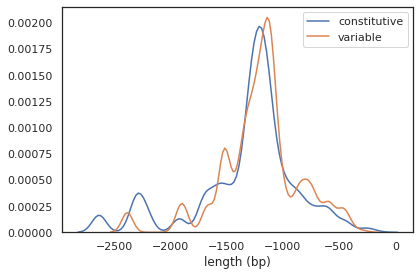

In [61]:
plot_length(GC_prom_types_length,'Czechowski_genetypenocontrol', genetype='constitutive', genetype2='variable')

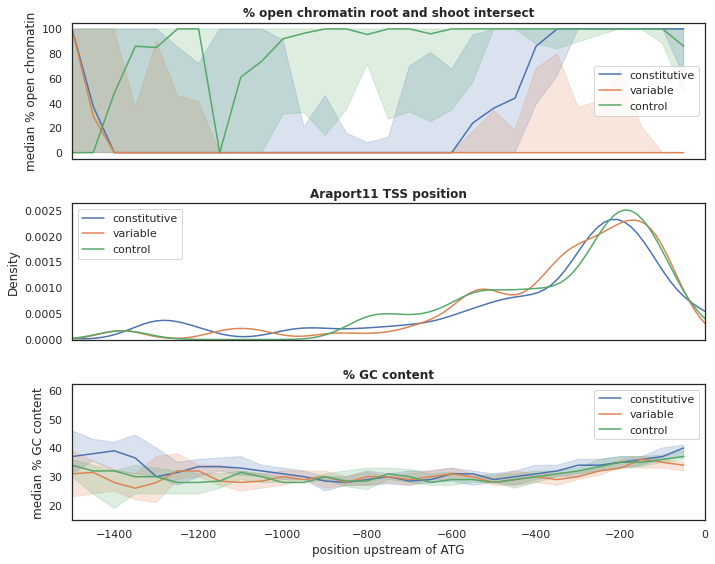

In [64]:
rolling_incl_control = windows_coords('Czechowski_genetype','percentage_GC_content','% GC content',GC_prom_types,
                                      promoter_bed,promoter_no_5UTR, 50,EPD_TSS_bed,includeEPDTSS=False,estimator='median',x_range=1500,
                                      genetype='constitutive', genetype2='variable', genetype3='control')

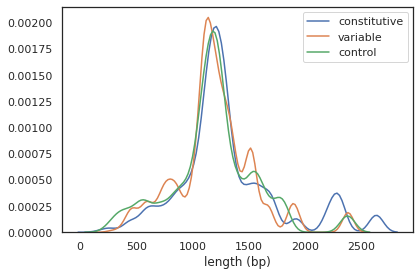

In [62]:
plot_length(GC_prom_types_length,'Czechowski_genetype', genetype='constitutive', genetype2='variable', genetype3='control')